In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from string_ga import calculateScore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('./generated_drugs/cl_f_5.csv')
df

,score,string
0,-0.022455,CCc1cc(-n2c(C)cc(C[NH2+]C(C)c3ccc(F)c(F)c3)c2C...
1,-0.024846,OC(Cl)N1CCc2ccc(Cl)cc2C1
2,-0.028278,Clc1ccc(C2(Cl)CCC2)cc1Cl
3,-0.031211,C=CCN1CCCCC=C([NH+]C2(c3ccc(Cl)c(Cl)c3)CCC2)C1=O
4,-0.035590,CC1(c2ccc(Cl)c(Cl)c2)CCC1
...,...,...
95,-0.139470,CC(C)(C)S(=O)CCN1C=Cc2ccccc2C1
96,-0.141650,O=C(NC(NC(=S)Nc1ccccc1)C(Cl)(Cl)Cl)C1=CC=C1
97,-0.141972,CC(C)CN(NC1CCOC1)C1(c2ccc(Cl)c(Cl)c2)CCC1
98,-0.142048,CCC(NC(NC(=S)Nc1ccccc1)C(Cl)(Cl)Cl)c1cccc(Br)c1


In [5]:
mols = [Chem.MolFromSmiles(i) for i in df['string']]

In [6]:
np.average(sas := [calculateScore(i) for i in mols])

3.2485058814678784

3.112319192607252


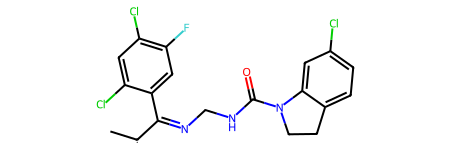

In [7]:
n = 18
print(calculateScore(mols[n]))
mols[n]

In [8]:
len([i for i in sas if i >= 4])

0

In [9]:
np.average(wts := [Descriptors.ExactMolWt(Chem.MolFromSmiles(i)) for i in df['string']])

331.0354449217717

In [10]:
len([i for i in wts if i < 200 or i > 500])

0

In [11]:
scores = pd.read_csv('./generated_drugs/cl_f_5_scores.csv')

In [12]:
parsed_scores = [[j for j in i[1].to_list() if j > -20] for i in scores.iterrows()]

In [13]:
maxes = [np.max(i) for i in parsed_scores]
avgs = [np.average(i) for i in parsed_scores]
mins = [np.min(i) for i in parsed_scores]

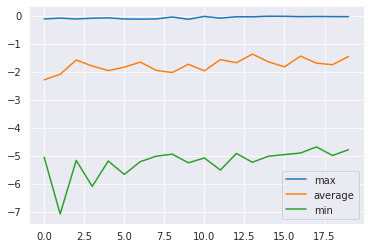

In [14]:
sns.set_style('darkgrid')

plt.plot(maxes, label='max')
plt.plot(avgs, label='average')
plt.plot(mins, label='min')
plt.legend()

plt.show()

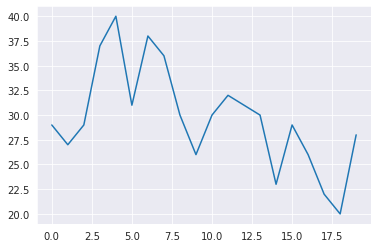

In [15]:
plt.plot([len([j for j in i[1].to_list() if j <= -20]) for i in scores.iterrows()])
plt.show()

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import numpy as np
import pandas as pd
import json
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras import models
from smiles_tools import return_tokens
from smiles_tools import SmilesEnumerator
from c_wrapper import seqOneHot
from ml_scorer import get_score
import string_ga
from functools import lru_cache

In [18]:
def get_lipinski(molecule):
    lipi = 0

    h_bond_donors = Lipinski.NumHDonors(molecule)
    h_bond_acceptors = Descriptors.NumHAcceptors(molecule)
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)

    if h_bond_donors <= 5:
        lipi += .25
    if h_bond_acceptors <= 10:
        lipi += .25
    if 200 <= molecular_weight <= 500:
        lipi += .25
    if logp <= 5:
        lipi += .25

    return lipi   

def get_custom_lipinski(molecule):
    # generationThreshold = string_ga.current_generation['gen'] > contents['generations'] / 2
    weightThreshold = 200 >= Descriptors.ExactMolWt(molecule)
    saThreshold = string_ga.calculateScore(molecule) > 4

    if weightThreshold or saThreshold:
        return 0
    else: 
        return get_lipinski(molecule)
    
def limit_rings(molecule):
    ring_lens = [len(ring) for ring in molecule.GetRingInfo().AtomRings() 
                if molecule.GetAtomWithIdx(ring[0]).GetSymbol() == 'C']
    for i in ring_lens:
        if i > 6:
            return 0
    
    return 1

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

def get_pains(molecule):
    isPAINS = catalog.GetFirstMatch(molecule)
    return int(isPAINS is None)

In [30]:
contents = {
    "scoring_function" : ["dopa_rnn_model.h5", "sero_rnn_model.h5", "custom_lipinski", "pains", "limit_rings"],
    "max_len" : 196,
    "target" : [1, 0, 1, 0, 1, 1, 1],
    "augment" : ["true", 5],
}

In [23]:
def get_pains(molecule):
    isPAINS = catalog.GetFirstMatch(molecule)
    return int(isPAINS is None)

drug_likeness_parser = {
    'lipinski': get_lipinski, 
    'custom_lipinski': get_custom_lipinski,
    'pains': get_pains,
    'limit_rings': limit_rings,
}
drug_likeness_metric = [drug_likeness_parser[i] for i in contents['scoring_function'] if '.h5' not in i]

vocab = pd.read_csv('../preprocessor/vocab.csv')['tokens'].to_list()
tokenizer = {i : n for n, i in enumerate(vocab)}

potential_models = [i for i in contents['scoring_function'] if '.h5' in i]
if len(potential_models) > 0:
    models_array = [models.load_model(i) for i in potential_models]
    print('Compiling models...')
    [model.compile() for model in models_array]
    max_len = contents['max_len']
    seq_shape = np.array([max_len, np.max([i+1 for i in tokenizer.values()])+1], dtype=np.int32)
    model_pred = True
else:
    model_pred = False

Compiling models...


In [33]:
def ensemble_predict(tokens):
    initial_seq = np.array([tokenizer[i]+1 for i in tokens])
    full_seq = np.hstack([np.zeros(max_len-len(initial_seq)), initial_seq])
    full_seq = seqOneHot(np.array(full_seq, dtype=np.int32), seq_shape).reshape(1, *seq_shape)
    
    return np.hstack([i.predict(full_seq, verbose=0) for i in models_array])

def augment_smiles(string, n):
    sme = SmilesEnumerator()
    output = []
    for i in range(n):
        output.append(sme.randomize_smiles(string))
    
    return output

def get_augs(string, n):
    strings = [string] + augment_smiles(string, n)
    tokens_array = [return_tokens(i, vocab)[0] for i in strings]

    full_seqs = []
    for tokens in tokens_array:
        if any([i not in vocab for i in tokens]):
            continue
        
        initial_seq = np.array([tokenizer[n]+1 for n in tokens])
        full_seq = np.hstack([np.zeros(max_len-len(initial_seq)), initial_seq])
        full_seq = seqOneHot(np.array(full_seq, dtype=np.int32), seq_shape).reshape(1, *seq_shape)
        full_seqs.append(full_seq[0])

        ####################################################################################
        # may want to reformat to while loop to see if we can still reach n many compounds #
        ####################################################################################

    return np.array(full_seqs)

@lru_cache(maxsize=256)
def no_model_scoring(string, target):
    _, isNotValidToken = return_tokens(string, vocab)

    if isNotValidToken:
        return -100
    else:
        molecule = Chem.MolFromSmiles(string)
        likeness_score = np.array(np.hstack([metric(molecule) for metric in drug_likeness_metric]))
        return -1 * get_score(likeness_score, np.array(target))

@lru_cache(maxsize=256)
def model_scoring(string, scoring_args):
    target, aug, num_of_augments = scoring_args

    tokens, isNotValidToken = return_tokens(string, vocab)
    if isNotValidToken or len(tokens) > max_len:
        return -100

    molecule = Chem.MolFromSmiles(string)
    likeness_score = np.array(np.hstack([metric(molecule) for metric in drug_likeness_metric]))
    
    if not aug:
        pred = ensemble_predict(tokens)[0]
        return -1 * get_score(np.hstack([pred, likeness_score]), np.array(target))
    else:
        augs = get_augs(string, num_of_augments)        
        pred = np.hstack([i.predict(augs, verbose=0) for i in models_array]).sum(axis=0) / len(augs)
        
        return np.hstack([pred, likeness_score])

#         if strict and not (200 <= Descriptors.ExactMolWt(molecule) <= 500):
#             return -20  
#         else:
#             return -1 * get_score(np.hstack([pred, likeness_score]), np.array(target)) 

In [47]:
scoring_args = tuple(contents['target'])

In [48]:
if model_pred:
    scoring_args = [scoring_args]
    if contents['augment'][0]:
        scoring_args.append(contents['augment'][0])
        scoring_args.append(contents['augment'][1])
    else:
        scoring_args.append(False)
        scoring_args.append(0)
    scoring_args[0] = tuple(scoring_args[0])

    scoring_function = model_scoring
else:
    scoring_function = no_model_scoring

scoring_args = tuple(scoring_args)

In [54]:
[round(i) for i in model_scoring(df['string'][0], scoring_args)]

[1, 0, 1, 0, 1, 1, 1]